## This script is used to plot the tune shift with amplitude.
- For the tune calculation the NAFF algorithm is used.
- Be careful each time to introduce the configuration file you need along with the file that contains the turn by turn data (from /afs)

In [1]:
import os
import sys
import numpy as np
from math import *
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import NAFFlib as pnf
import json

### Test that you have acces to the /afs directory where your data are stored
If permision denied
- $USERNAME@CERN.CH 
- aklog

In [2]:
ls /afs/cern.ch/work/n/natriant/private

my_tracking_model_htcondor/  simulation_data_2018/  sixdesk/  workspaces/


### Plotting parameters

In [3]:
params = {'legend.fontsize': 12,
          'figure.figsize': (8.5, 6.5),
          'axes.labelsize': 25,
          'axes.titlesize': 25,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

### Import the parameters of the study

In [5]:
data = {}
with open('./configuration_files/config_rate_vs_noise.json', "r") as read_file:
        data = json.load(read_file)
my_afs_path = '/afs/cern.ch/work/n/natriant/private/my_tracking_model_htcondor/tracking_data/'

### Define the set of parameters of the study

In [6]:
Delta_1 = 0.032
Delta_2 = 1.0
version = 1
df_1 = pd.read_pickle(my_afs_path+'Qx62.78_ksi0.005_g0.200_delta{:.3f}_betax115.75_particles15000_turns1000_v{}.pkl'.format(Delta_1, version))
df_2 = pd.read_pickle(my_afs_path+'Qx62.78_ksi0.005_g0.200_delta{:.3f}_betax115.75_particles15000_turns1000_v{}.pkl'.format(Delta_2, version))

### Tune shift with amplitude
- We need to store the data in groups of particles. 
- In our data frames are in groups of turns

In [7]:
x1_data = {}
px1_data = {}
x2_data = {}
px2_data = {}
for particle in range(data['study_parameters']['particles']):
    x1_data[particle] = []
    px1_data[particle] = []
    x2_data[particle] = []
    px2_data[particle] = []

In [ ]:
for particle in range(data['study_parameters']['particles']):
    for turn in range(data['study_parameters']['turns']):
        x1_data[particle].append(df_1.at[turn,'x'][particle])
        px1_data[particle].append(df_1.at[turn,'px'][particle])
        x2_data[particle].append(df_2.at[turn,'x'][particle])
        px2_data[particle].append(df_2.at[turn,'px'][particle])

### Exclude the particles that are lost, otherwise NAFF crashes.

In [13]:
lost_particles_1 = []
lost_particles_2 = []
Qx_list_1 = []
Qx_list_2 = []

for particle in range(data['study_parameters']['particles']):
    if np.isnan(x1_data[particle]).any() or np.isnan(px1_data[particle]).any():
        lost_particles_1.append(particle)
        print('particle {} lost'.format(particle))
    else:        
        signal_x_1 = x1_data[particle] # normalise by derivation with beta function
        Qx_list_1.append(pnf.get_tune(np.array(signal_x_1)))
    
    if np.isnan(x2_data[particle]).any() or np.isnan(px2_data[particle]).any():
        lost_particles_2.append(particle)
        print('particle {} lost'.format(particle))
    else:        
        signal_x_2 = x2_data[particle] # normalise by derivation with beta function
        Qx_list_2.append(pnf.get_tune(np.array(signal_x_2)))  

### Use normalised coordiantes
\begin{equation}
x_{N} = \frac{x}{\sqrt{\beta(s)}} \\
px_{N} = px \cdot \sqrt{\beta(s)}
\end{equation}

### Calculate initial actions Jx
\begin{equation}
J_x = \frac{x_{N}^2 + px_{N}^2}{2} 
\end{equation}

In [14]:
flag_initial_actions = False
if flag_intial_actions:
    x1_norm = df_1.at[0,'x']/sqrt(data['machine_parameters']['beta_x']) # the index 0 corresponds to turn
    px1_norm = df_1.at[0,'px']*sqrt(data['machine_parameters']['beta_x'])
    Jx_initial_1 = (x1_norm**2 + px1_norm**2)

    x2_norm = df_2.at[0,'x']/sqrt(data['machine_parameters']['beta_x']) # the index 0 corresponds to turn
    px2_norm = df_2.at[0,'px']*sqrt(data['machine_parameters']['beta_x'])
    Jx_initial_2 = (x2_norm**2 + px2_norm**2)

### Calculate the avereged actions over turns

In [15]:
# the indeces 1, 2 corrsepond to the first and second time integral respectively
flag_average_actions = True
if flag_average_actions:
    Jx_mean_1 = [] # Here you will save the average actions for each particle over the first and last 1000 turns
    Jx_data_1 = {}
    Jx_mean_2 = [] # Here you will save the average actions for each particle over the first and last 1000 turns
    Jx_data_2 = {}
    for particle in range(data['study_parameters']['particles']):
        Jx_data_1[particle] = []
        Jx_data_2[particle] = []

        Jx_data_1[particle] = (np.array(x1_data[particle])/sqrt(data['machine_parameters']['beta_x']))**2 + (np.array(px1_data[particle])*sqrt(data['machine_parameters']['beta_x']))**2
        Jx_data_2[particle] = (np.array(x2_data[particle])/sqrt(data['machine_parameters']['beta_x']))**2 + (np.array(px2_data[particle])*sqrt(data['machine_parameters']['beta_x']))**2
        
        
        Jx_mean_1.append(np.mean(Jx_data_1[particle]))           
        Jx_mean_2.append(np.mean(Jx_data_2[particle]))

### Plot tune shift with amplitude

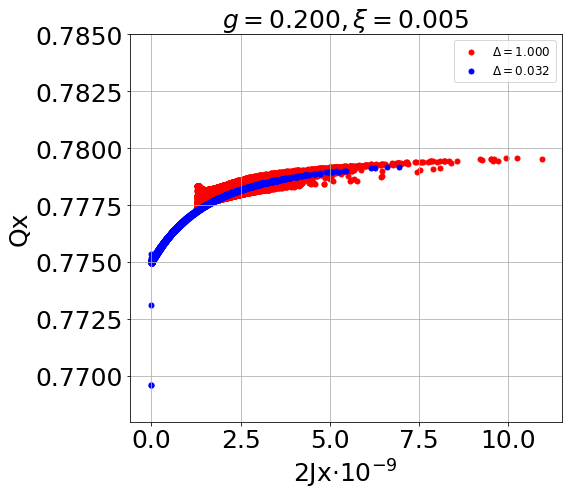

In [21]:
xi = 0.005
g =0.2
fig, ax = plt.subplots(1,1,figsize=(8,7))
Qx_list_plot_1 = [1-i for i in Qx_list_1]
Qx_list_plot_2 = [1-i for i in Qx_list_2]

ax.scatter(np.array(Jx_mean_2)*1e9, Qx_list_plot_2, c ='r', label = r'$\Delta={:.3f}$'.format(Delta_2)) # the index 0 corresponds to turn
ax.scatter(np.array(Jx_mean_1)*1e9, Qx_list_plot_1, c ='b', label = r'$\Delta={:.3f}$'.format(Delta_1)) # the index 0 corresponds to turn

ax.set_xlabel('2Jx'+r'$\cdot 10^{-9}$')
ax.set_ylabel('Qx')
#ax.set_title(r'$g={:.3f}, \xi={:.3f}$'.format(data['Feedback']['values_limits']['max'],data['BB']['values_limits']['max'])+'\n'+'$Q_x={}, turns={}, N_b={}$'.format(data['machine_parameters']['Qx_init'], data['study_parameters']['turns'], data['study_parameters']['particles'] ))
ax.set_title(r'$g={:.3f}, \xi={:.3f}$'.format(g, xi))

#ax.set_ylim(0.768, 0.785)
plt.tight_layout()
plt.grid()
plt.legend()
savefig = False
if savefig:
    plt.savefig('./figures/tune_shift_Qx62.78_ksi0.005_g0.200_delta{:.3f}_and{:.3f}_betax115.75_particles15000_turns1000_v{}_cut.png'.format(Delta_1, Delta_2, version))